In [4]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from typing import Tuple

In [ ]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20221020'
}

In [ ]:
q = """
select user_id,
exp_group, 
countIf(action='like') as likes,
countIf(action='view') as views, 
likes / views as ctr
from {db}.feed_actions
where toDate(time) >= '2022-10-03' and toDate(time) <= '2022-10-09'
and exp_group in (1, 2)
group by exp_group, user_id
"""

In [ ]:
df_ab = ph.read_clickhouse(q, connection=connection)

In [ ]:
df_ab

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,33,122,0.270492
4,18392,1,7,32,0.218750
...,...,...,...,...,...
20026,132567,1,45,296,0.152027
20027,30872,1,11,59,0.186441
20028,25383,2,42,127,0.330709
20029,139020,2,24,114,0.210526


In [ ]:
group_a = df_ab[df_ab['exp_group'] == 1]['ctr'] # контрольная группа
group_b = df_ab[df_ab['exp_group'] == 2]['ctr'] # экпериментальная группа

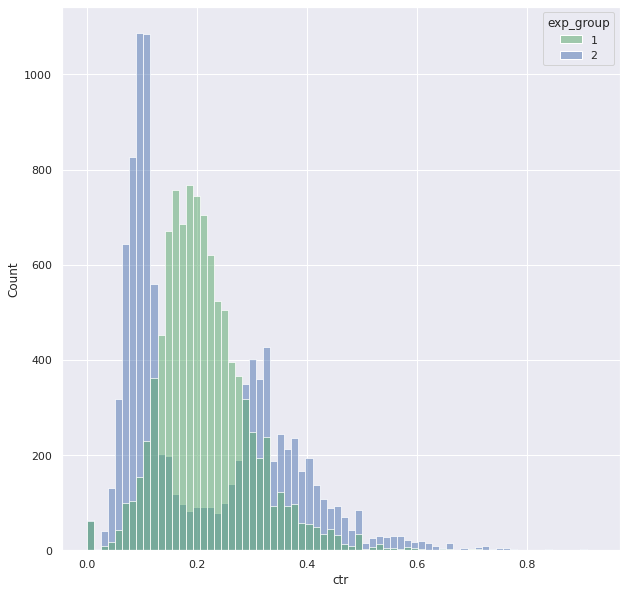

In [ ]:
sns.histplot(data=df_ab,
             x='ctr',
             hue='exp_group',
             palette=['g', 'b'],
             kde=False,
             alpha=0.5);

Распределение ctr первой группы напоминает нормальное распределение. 

Распределение ctr второй группы не похоже на нормальное, т.к. оно имеет две моды. Такая форма распределения может быть вызвана тем, что после выкатывания нового алгоритма пользователи поделились на тех, кому не понравилась новая рекомендательная система, и они стали лайкать меньше. И на тех, кому новая система понравилось, и их CTR стал в среднем больше по сравнению со среднем CTR в контрольной группе. 

## Testing 

### ttest

In [ ]:
st.ttest_ind(group_a, group_b, equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

In [ ]:
group_a.mean(), group_b.mean()

(0.21560459841296287, 0.21441927347479375)

### Mann-Witney test

In [ ]:
st.mannwhitneyu(group_a, group_b, alternative='two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

**Вывод:**

t-критерий Стьдента не показывает стат. значимое различие, т.к. p-value > 0.05. Такой результат вызван тем, что распределение ctr экспериментальной группы не является нормальным, и использование данного теста было некорректно.

Тест Манна-Уитни показывает стат. значимые различия, что в целом соответствует представленным распределениям

### Smoothed CTR

In [ ]:
def get_smoothed_ctr(user_likes: pd.Series,
                     user_views: pd.Series,
                     global_ctr: int,
                     alpha: int = 5
) -> pd.Series:
    smoothed_ctr = (user_likes +  alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [ ]:
# считаем общий ctr в контрольной и тестовой группах
global_ctr_1 = df_ab[df_ab['exp_group'] == 1]['likes'].sum() / df_ab[df_ab['exp_group'] == 1]['views'].sum()
global_ctr_2 = df_ab[df_ab['exp_group'] == 2]['likes'].sum() / df_ab[df_ab['exp_group'] == 2]['views'].sum()

In [ ]:
global_ctr_1, global_ctr_2

(0.20802680490126244, 0.1980601844115994)

In [ ]:
group_1 = df_ab[df_ab['exp_group'] == 1]
group_2 = df_ab[df_ab['exp_group'] == 2]

In [ ]:
group_1['smoothed_ctr'] = df_ab[df_ab['exp_group'] == 1].apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1), axis=1)
group_2['smoothed_ctr'] = df_ab[df_ab['exp_group'] == 2].apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2), axis=1)

In [ ]:
group_1

,user_id,exp_group,likes,views,ctr,smoothed_ctr
0,109963,1,3,15,0.200000,0.202007
1,26117,1,32,141,0.226950,0.226302
2,138232,1,18,73,0.246575,0.244104
3,26295,1,33,122,0.270492,0.268033
4,18392,1,7,32,0.218750,0.217301
...,...,...,...,...,...,...
20020,31540,1,8,45,0.177778,0.180803
20021,23359,1,23,91,0.252747,0.250418
20024,110956,1,3,16,0.187500,0.192387
20026,132567,1,45,296,0.152027,0.152957


In [ ]:
group_2

,user_id,exp_group,likes,views,ctr,smoothed_ctr
5,131473,2,14,134,0.104478,0.107844
6,23985,2,7,87,0.080460,0.086851
7,24523,2,11,101,0.108911,0.113116
8,32420,2,26,128,0.203125,0.202935
9,24239,2,40,90,0.444444,0.431477
...,...,...,...,...,...,...
20023,16512,2,1,15,0.066667,0.099515
20025,17146,2,0,10,0.000000,0.066020
20028,25383,2,42,127,0.330709,0.325684
20029,139020,2,24,114,0.210526,0.210003


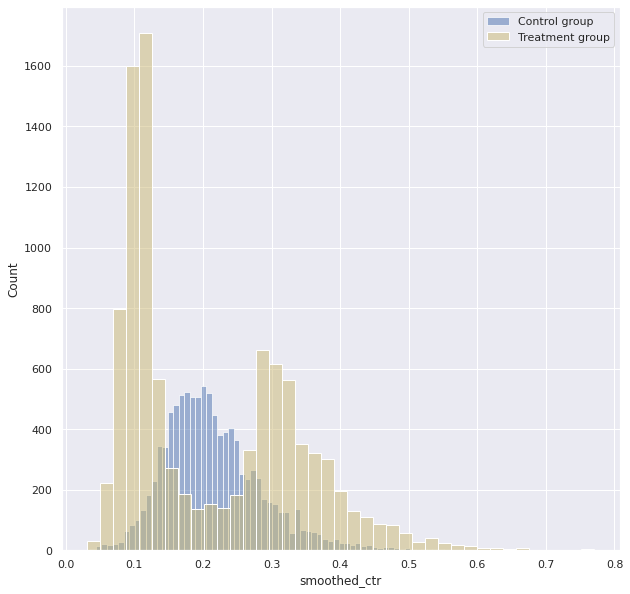

In [ ]:
sns.histplot(group_1['smoothed_ctr'],
             color='b',
             alpha=0.5,
             kde=False);
sns.histplot(group_2['smoothed_ctr'],
             color='y',
             alpha=0.5,
             kde=False);
plt.legend(labels=['Control group', 'Treatment group']);

**ttest**

In [ ]:
st.ttest_ind(group_1['smoothed_ctr'], group_2['smoothed_ctr'], equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [ ]:
# средние в контрольниой и тестовой группах
group_1['smoothed_ctr'].mean(), group_2['smoothed_ctr'].mean()

(0.21402549608884142, 0.21073955503259234)

**Mann-Witney test**

In [ ]:
st.mannwhitneyu(group_1['smoothed_ctr'], group_2['smoothed_ctr'], alternative='two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

**Вывод:**

На сглаженном ctr ttest, в отличие от обычного ctr, показывает стат. значимое различие. Тест Манна-Уитни по-прежнему показывает различие.

### Poisson bootstrap

In [5]:
def poisson_bootstrap(likes1: np.ndarray,
                      views1: np.ndarray,
                      likes2: np.ndarray,
                      views2: np.ndarray,
                      n_bootstrap: int = 10000
) -> Tuple[np.ndarray, np.ndarray]:
    btstrp_samples_1 = st.poisson(1).rvs((n_bootstrap, len(likes1)))
    btstrp_samples_2 = st.poisson(1).rvs((n_bootstrap, len(likes2)))

    global_ctr_1 = (btstrp_samples_1 * likes1).sum(axis=1) / (btstrp_samples_1 * views1).sum(axis=1)
    global_ctr_2 = (btstrp_samples_2 * likes2).sum(axis=1) / (btstrp_samples_2 * views2).sum(axis=1)

    return global_ctr_1, global_ctr_2

In [ ]:
likes1 = df_ab[df_ab.exp_group == 1]['likes'].to_numpy()
likes2 = df_ab[df_ab.exp_group == 2]['likes'].to_numpy()
views1 = df_ab[df_ab.exp_group == 1]['views'].to_numpy()
views2 = df_ab[df_ab.exp_group == 2]['views'].to_numpy()

In [ ]:
ctr_1, ctr_2  = poisson_bootstrap(likes1, views1, likes2, views2)

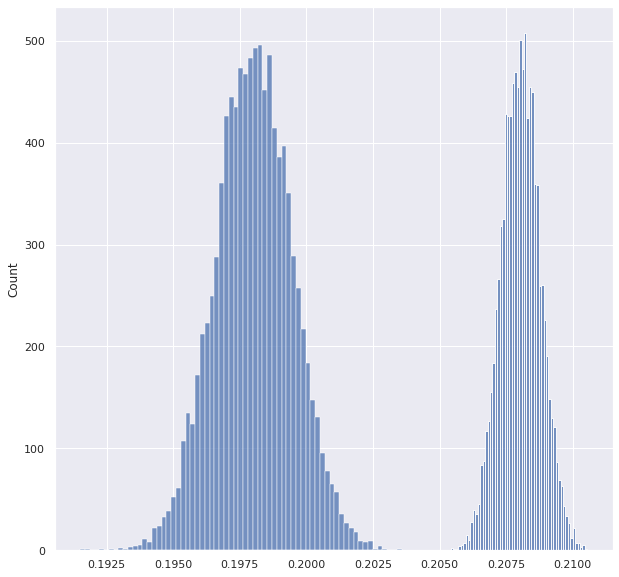

In [ ]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.histplot(ctr_1)
sns.histplot(ctr_2);

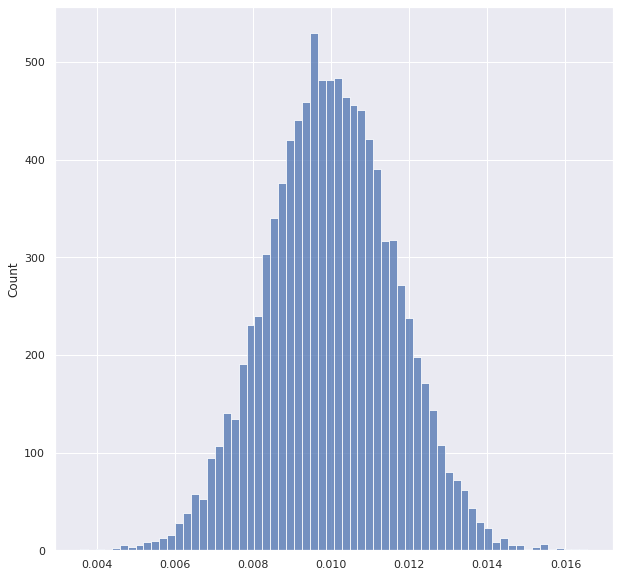

In [ ]:
sns.histplot(ctr_1 - ctr_2)

**Вывод:** 

Распределение глобального ctr показывает, что ctr в тестовой группе стал меньше для каждой бустрап-подвыборки

### Бакетное преобразование

In [ ]:
q = """
select
  exp_group,
  bucket,
  sum(likes) / sum(views) as bucket_ctr
from
  (
    SELECT
      exp_group,
      xxHash64(user_id) % 50 as bucket,
      user_id,
      sum(action = 'like') as likes,
      sum(action = 'view') as views,
      likes / views as ctr
    FROM
      simulator_20221020.feed_actions
    where
      toDate(time) >= '2022-10-03'
      and toDate(time) <= '2022-10-09'
      and exp_group in (1, 2)
    GROUP BY
      exp_group,
      bucket,
      user_id
  )
group by
  bucket,
  exp_group
"""

In [ ]:
df_bucket = ph.read_clickhouse(q, connection=connection)
df_bucket

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,1,1,0.211887
2,1,2,0.206271
3,1,3,0.203733
4,1,4,0.209739
...,...,...,...
95,2,45,0.179901
96,2,46,0.192589
97,2,47,0.195880
98,2,48,0.194502


**ttest**

In [ ]:
st.ttest_ind(df_bucket[df_bucket['exp_group'] == 1]['bucket_ctr'],
             df_bucket[df_bucket['exp_group'] == 2]['bucket_ctr'],
             equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

**Mann-Witney test**

In [ ]:
st.mannwhitneyu(df_bucket[df_bucket['exp_group'] == 1]['bucket_ctr'],
                df_bucket[df_bucket['exp_group'] == 2]['bucket_ctr'],
                alternative='two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

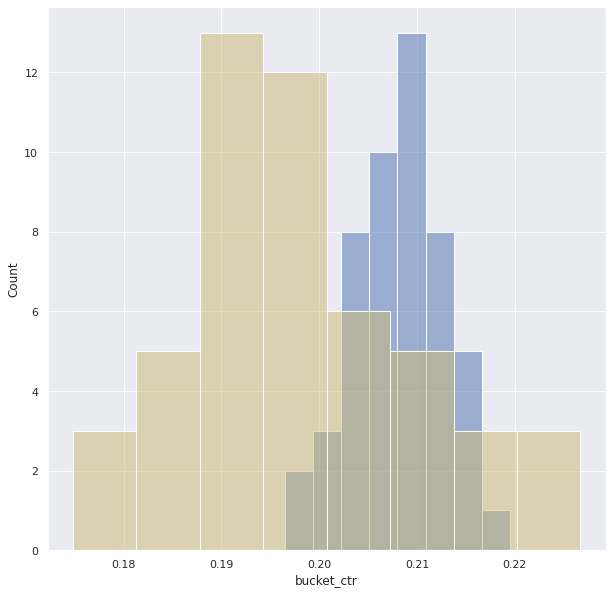

In [ ]:
sns.histplot(df_bucket[df_bucket['exp_group'] == 1]['bucket_ctr'],
             color='b',
             alpha=0.5,
             kde=False)
sns.histplot(df_bucket[df_bucket['exp_group'] == 2]['bucket_ctr'],
             color='y',
             alpha=0.5,
             kde=False);

**Вывод:** 

Оба теста показывают стат. значимое различие, что также визуально видно на распределениях (среднее тестовой группы смещено). Также стоит отметить, что распределение бакетного ctr напоминает нормальное. 

### Заключение



Таким образом, было проведено A/B тестирование при помощи ttest'а Стьюдента и теста Манна-Уитни, а также при помощи различных методов, таких как: сглаживание CTR, Пуассоновский бутстреп, бакетное преобразование. 
Как уже было отмечено, между контрольной и тестовой группами наблюдается стат. значимое различие, что проявляется как в сравнении поюзерного CTR, так и глобального. Причем, как показали Пуассоновский бутстрап и бакетное преобразование, в среднем глобальный CTR уменьшился. Поэтому **не рекомендуется** раскатывать новый алгоритм на всех пользователей. 